# GrantRank Whitepaper

## Abstract


# Setup

In [1]:
import pygraphviz as pgv
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors
from IPython.display import SVG
import pydot
import warnings
from IPython.display import display, Markdown, Latex


warnings.filterwarnings("ignore", category=DeprecationWarning) 

cmap = matplotlib.colormaps['tab10']


def markdown(text):
    display(Markdown(text))

def visualize_network_pagerank(path, personalized=True):
    G_pydot = pydot.graph_from_dot_file(path)[0]


    G_pydot.get_subgraphs()[0].get_nodes()[0].get_name()

    # Convert the graph to networkx, label the nodes with the subgraphs they belong to
    G = nx.nx_pydot.from_pydot(G_pydot)

    # Bugfix in the networkx conversion
    G.remove_node(r'\n')

    def parse_graph(G_pydot, parents=set()):
        for subgraph in G_pydot.get_subgraphs():
            for node in subgraph.get_nodes():
                G.nodes[node.get_name()][subgraph.get_name()] = subgraph.get_label()[1:-1]
                G.nodes[node.get_name()]['lowest_cluster'] = subgraph.get_label()[1:-1]
                G.nodes[node.get_name()]['highest_cluster'] = subgraph.get_label()[1:-1]
                for parent in parents:
                    G.nodes[node.get_name()][parent[0]] = parent[1]
                    G.nodes[node.get_name()]['highest_cluster'] = parent[1][1:-1]
            parse_graph(subgraph, parents.union({(subgraph.get_name(), subgraph.get_label())}))

    parse_graph(G_pydot)
    clusters = sorted(list(set( node[1].get('lowest_cluster', 'No Cluster') for node in G.nodes(data=True) )))
    coloured_clusters= clusters.copy()
    try:
        coloured_clusters.remove('Sybil Organisations')
    except:
        pass
    coloured_clusters.insert(3, 'Sybil Organisations')
    
    colormap = {v:cmap(i) for i, v in enumerate(coloured_clusters)}

    for node in G.nodes:
        G.nodes[node]['color'] = mcolors.to_hex(colormap[G.nodes[node].get('lowest_cluster', 'No Cluster')])

    voters = [node for node in G.nodes if G.nodes[node].get('highest_cluster') == 'Voters']

    personalized_pagerank = nx.pagerank(G, personalization={node: 1 for node in voters}, alpha=0.85) if personalized else nx.pagerank(G, alpha=0.85)

    # Assign the personalized pagerank to the nodes

    for node in G.nodes:
        G.nodes[node]['personalized_pagerank'] = personalized_pagerank[node]

    # Draw the graph

    nx.draw(G, with_labels=True, node_color=[G.nodes[node]['color'] for node in G.nodes], node_size=[G.nodes[node]['personalized_pagerank']*10000 for node in G.nodes], pos=nx.nx_agraph.graphviz_layout(G))

    # Create a legend for the colours
    patches = [matplotlib.patches.Patch(color=colormap[key], label=key) for key in clusters]

    plt.legend(handles=patches)
    plt.show()

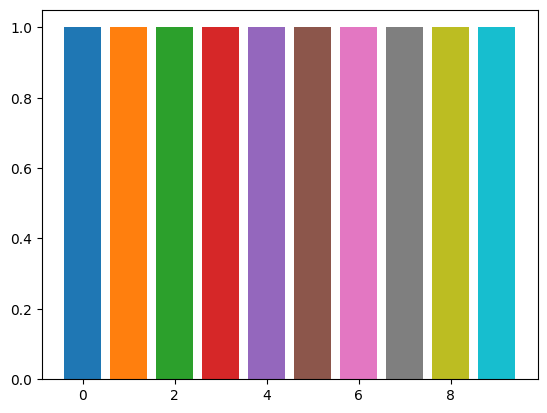

In [2]:
# Display the colourmap
for i in range(10):
    plt.bar(i, 1, color=cmap(i))


# Background and Motivation




## Fiduciary Networks

As discussed in Toby Ord's _The Precipice_ humanity has entered a uniquely risky period of time. Failure to navigate this period successfully could result in the extinction of humanity. In addition to posing existential risks, rapidly advancing technology has also partially disrupted some of our capacity to coordinate effectively, including around managing these risks. As such, it is important to explore mechanisms that could help us to manage these risks and coordinate effectively.

For coordination to be effective, it seems likely that any methodology should:

#### Represent everyone's interests
When co-ordinating around risks that can be posed effectively unilaterally, it is important that the co-ordination mechanism represents the interests of all actors. If it does not, then actors who are not represented could be incentivised to act unilaterally, which may lead to the failure of the co-ordination mechanism.
#### Be sufficiently dynamic to cope with rapidly changing circumstances

#### Be sufficiently robust to cope with the failure of individual actors

#### Be sufficiently efficient to cope with the scale of the problem

## Existing institutions

### Government
It is instructive to consider how coordination and fiduciary responsibility is already managed in the context of government. In most countries, some explicit or implicit contract is held whereby the government is given fiduciary responsibility on behalf of the people. While citizens may not have the time, knowledge or individual resources to effectively decide policy or execute actions that they perceive to be for the public good, they can delegate this responsibility to a representative. The representative themselves also has to delegate a lot of this responsibility to other people, such as civil servants, who act as part of the government and are in turn responsible for delegating to other people and organisations. This is a fiduciary network. The nature of handling responsibility may take several non-exclusive forms:

- Stewardship
- Actions
- Decisions

Whilst not all of these require or expect significant resources, what we can notice is that the network still essentially functions in part as a way of distributing resources based on directed responsibility. 


## Fiduciary Network in Governance

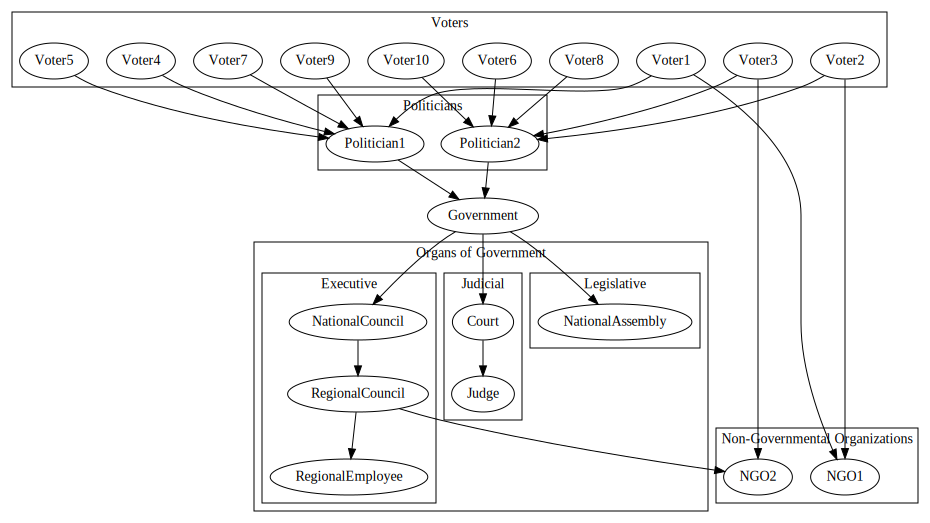

In [3]:
markdown('## Fiduciary Network in Governance')
Gtmp = pgv.AGraph('networks/fiduciary.dot')
Gtmp.draw('fiduciary.png', prog='dot', format='svg')
SVG('fiduciary.png')



We can consider the flow of responsibility as modelled by a transition matrix, where each element represents the proportion of responsibility being delegated from one actor to another. Therefore we can model the accumulated flow of responsibility using personalised pagerank where humans are treated as the seed nodes. This allows for a model of accumulated responsibility that is proportionally representative.


## Personalised PageRank applied to the Fiduciary Network
By applying personalised PageRank with the voters as the seed nodes, we can see the accumulation and distribution of responsibility in the network.

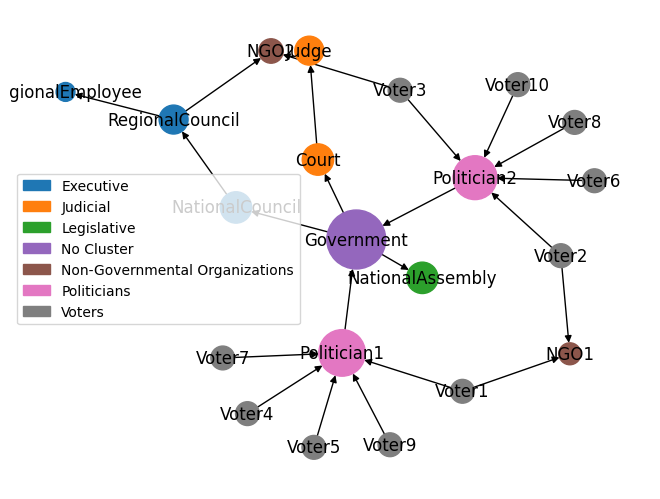

In [4]:
markdown('''## Personalised PageRank applied to the Fiduciary Network
By applying personalised PageRank with the voters as the seed nodes, we can see the accumulation and distribution of responsibility in the network.''')
visualize_network_pagerank('networks/fiduciary.dot')

# GrantRank

GrantRank is implemented on the following assumptions:
1) Transition matrices effectively model an equitable and proportional distribution of public trust
2) Action scales with the amount of available resources
3) Therefore, proportional representation of action and responsibility is roughly equivalent to distributing resources according to the pagerank of the transition matrix


## Implementation
### Accounts
We allow for accounts for both humans and organisations. Organisations may in future extend smart contracts on their creation. This allows for standardisation in the functioning and restrictions applying to differnt types of organisations. As humans occupy a priviledged position in the network as sources of responsibility, human accounts must be effectively verified to prevent manipulation. We rely on [WorldCoin](https://worldcoin.org/world-id) for this purpose.

### Trust Network and Ranking
Trust is granted from one account to another via interaction with a smart contract. The pagerank is computed offchain and retrieved by chainlink. The pagerank directly determines the amount of resources that are available to an account. 

### Budgets
In order to effectively allow for roles that are not directly responsible for action, but instead stewardship and/or decision making, there are a couple of obvious options:

1) Predefined roles with budget caps outside of the control of the role holder
2) Budget caps that are controlled by the role holder

The first option is more robust to the failure of individual role holders, but is less flexible and may be less effective at distributing resources to the most effective actors. The second option is more flexible, but may be more vulnerable to the failure of individual role holders. In this project, we implement the second option, however in order to safeguard against unexpected withdrawal of resources, we implement a time delay on budget increases. As this information is public, it allows for the community to respond to unjustified excessive budget increases by withdrawing their support for the role holder.

### Discourse and Accountability
In order for the community to effectively discern trustworthy actors, it is important that they are able to scrutinise information posted by the actors. Additionally, fiduciary responsibility also extends to the responsible discussion of important issues and the dissemination of information. As such, we extend the trust network to rank posts and comments according to accumulated responsibility. We model this simply that there is a connection in the transition matrix from an account to its post/comment, and additional positive or negative connections determined by votes on the post/comment. 

## Resistance to manipulation
### Sybil attacks

<img src="https://petapixel.com/assets/uploads/2022/02/Spiderman-No-Way-Home-Meme-Cartoon-800x734.jpg"  width="40%">

A sybil attack is when a large number of accounts are made for the purposes of manipulating a network and without sincerely acting in accordance with the responsiblity granted. As long as humans are effectively verified, a significant responsibility that we outsource to WorldCoin, GrantRank is robust to manipulation from a malicious sybil attack.  As can be seen in the graph, even if the sybil organisations fool one voter, they do not gain dominance in the network, because only humans are sources of responsibility.

## Sybil Attack
Here we have a network with a sybil attack. The sybil nodes are colored in red, however they have a pagerank of 0, so they are not visible in the graph. This is because there is no path of trust from any human voter.

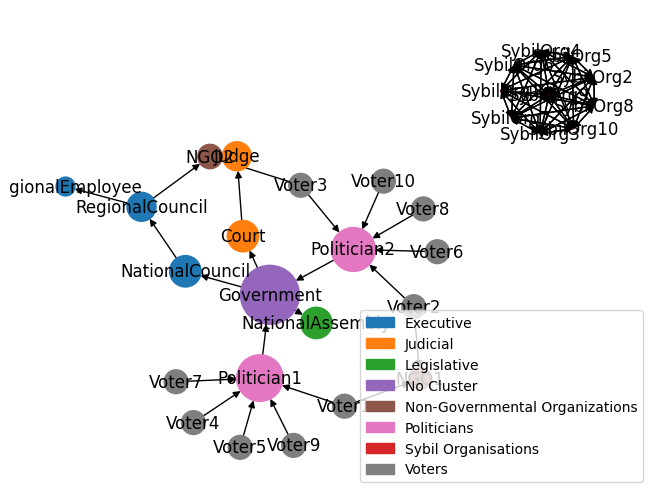

## Sybil Attack with convincing Sybil
If the Sybil nodes are convincing enough, they can convince a human voter to vote for them. However, the trust is stil only sourced from humans, so the sybil nodes do not have a high pagerank even though they are highly interconnected.

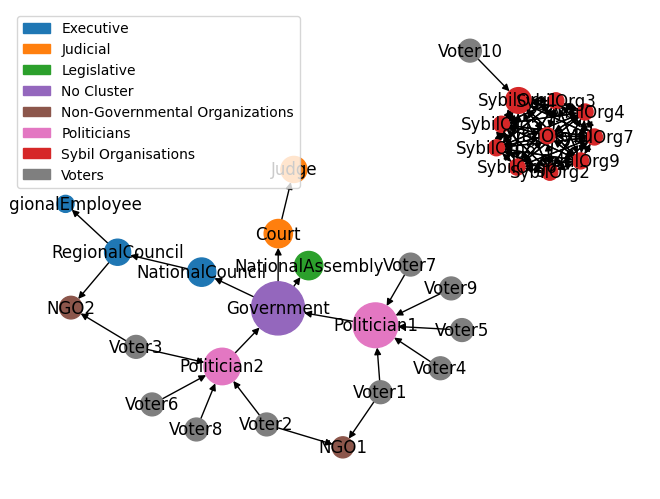

In [5]:
markdown('''## Sybil Attack
Here we have a network with a sybil attack. The sybil nodes are colored in red, however they have a pagerank of 0, so they are not visible in the graph. This is because there is no path of trust from any human voter.''')
visualize_network_pagerank('networks/sybil.dot')
markdown('''## Sybil Attack with convincing Sybil
If the Sybil nodes are convincing enough, they can convince a human voter to vote for them. However, the trust is stil only sourced from humans, so the sybil nodes do not have a high pagerank even though they are highly interconnected.''')
visualize_network_pagerank('networks/sybil-convincing.dot')



Without personalisation, or effective proof of personhood, the network would have some vulnerability to sybil attacks. This is because the sybil organisations can effectively create a large number of accounts as sources that are all connected to each other, and therefore have a high pagerank. As long as the number of voters significantly outnumbers the number of sybil organisations, this risk is partially mitigated as the sybils' pagerank will be relatively low, so account creation fees can also be considered to mitigate this risk. Educating users on how to determine legitimacy of accounts and making it easy for them to do so is another important mitigation step. However as with many other forms of organisation and collaboration, reliable proof of personhood would make the network significantly more resilient to manipulation, which we trust WorldCoin to provide.

## Sybil Attack without personalisation/proof of personhood
If we do not use personalised pagerank and an effective proof of personhood, the sybil nodes can gain a higher pagerank because they are highly interconnected. This is because the sybil nodes become sources in the network.

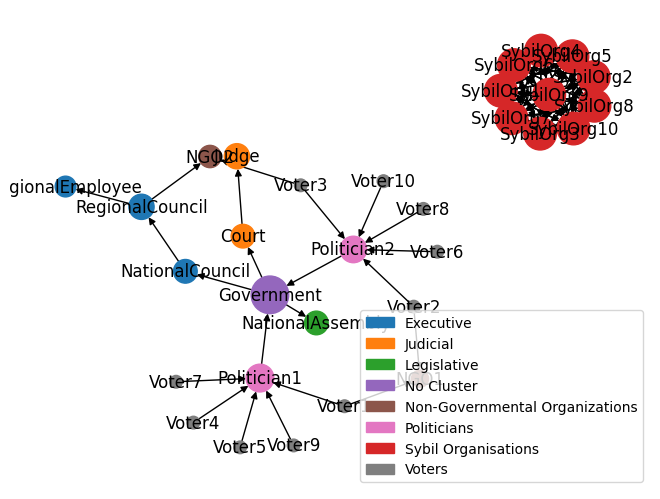

In [6]:
markdown('''## Sybil Attack without personalisation/proof of personhood
If we do not use personalised pagerank and an effective proof of personhood, the sybil nodes can gain a higher pagerank because they are highly interconnected. This is because the sybil nodes become sources in the network.''')
visualize_network_pagerank('networks/sybil.dot', personalized=False)

## MVP
1. GUI where users can create accounts and specify whether they are human
2. GUI to accept donations
3. User are able to declare their trust in other users to act in the best interest of sentient beings
4. Compute personalised pagerank off-chain (personalised with human users as source nodes)
5. Use the trust scores to periodically distribute donations

## Additional Features

- Display a portion of the network on the GUI
- Display a users individual contributions and local trust network on the GUI
- Use worldcoin as proof of personhood for human accounts
- Allow users to specify a budget and explanations for how they are using the funds. Use this budget to restrict withdrawal amounts. Increases in budget should be delayed by one month.
- Every 5 years, start decaying the preferences of people who have not updated their preferences in the prior 3 months. During this period, users must also choose whether to re-affirm their previous trust scores.
- Allow users to post and vote on posts and comments. Use this to rank posts and comments.

